## Hierarchical Clustering Asset Allocation vs. Hierarchical Risk Parity

## Abstract
This tutorial notebook will demonstrate the differences between the Hierarchical Clustering Asset Allocation and the Hierarchical Risk Party algorithms, applied through the MlFinLab library. Readers will be taken through how they can construct optimal portfolios utilizing both algorithms while understanding the main differences which separate them.

## Introduction

This tutorial notebook will serve as a comparison notebook demonstrating the differences between Thomas Raffinot's __[Hierarchical Equal Risk Contribution](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3237540)__ (HERC) and Dr. Marcos Lopez de Prado's __[Hierarchical Risk Parity](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__ (HRP) portfolio optimization algorithms. 

### Hierarchical Equal Risk Contribution
From Raffinot's description in his original paper, we can distill the HERC algorithm down into four steps:
1. Hierarchical clustering
2. Selecting the optimal number of clusters
3. Top-Down recursive bisection
4. Implement Naive Risk Parity within clusters to allocate weights to each asset


### Hierarchical Risk Parity
The HRP algorithm is quite similar to the HERC algorithm as they both use a hierarchical clustering technique at the beginning. Although, the algorithms differ in the latter steps. From Dr. Lopez de Prado, we can break down the HRP algorithm into three main steps:
1. Hierarchical clustering
2. Quasi-diagonalization
3. Recursive bisection

If you would like to learn more about the HCAA and HRP implementation through MlFinLab, please refer to the official documentation:
- __[Hierarchical Clustering Asset Allocation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__
- __[Hierarchical Risk Parity](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_risk_parity.html)__

In [2]:
# importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import yfinance as yf
from mlfinlab.portfolio_optimization.hcaa import HierarchicalClusteringAssetAllocation
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity

## The Data

In this tutorial, we will be working with the historical closing prices for 17 assets from 2010-2018. 

In [8]:
# preparing our data
raw_prices = pd.read_csv('assetalloc.csv', sep=';', parse_dates=True, index_col='Dates')
raw_prices = raw_prices.iloc[::-1]
x = raw_prices.index.get_loc('2010-01-01')
stock_prices = raw_prices.iloc[0:x[0], :]

stock_prices.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
2018-12-07,7651.33,3445.493,2798.29,1247.32,89.925,149.023,211.724,305.707,122.683,143.723,142.810,164.048,1690.28,257.795,5883.11,1070.241,436.10
2018-11-07,7591.96,3422.348,2774.02,1246.32,89.959,149.040,211.450,304.801,122.740,143.813,142.922,164.246,1683.66,256.298,5874.90,1064.715,434.89
2018-10-07,7692.04,3473.311,2793.84,1254.45,90.004,149.059,211.377,303.464,122.702,143.610,142.565,163.354,1695.62,258.043,5921.59,1076.188,438.66
2018-09-07,7687.99,3460.442,2784.17,1261.56,90.022,149.158,211.487,303.672,122.779,143.745,142.721,163.527,1704.60,256.680,5904.19,1075.738,437.79
2018-06-07,7617.70,3448.490,2759.82,1254.84,90.036,149.257,211.743,306.533,122.817,143.926,143.078,164.296,1694.05,255.104,5888.00,1059.968,437.12


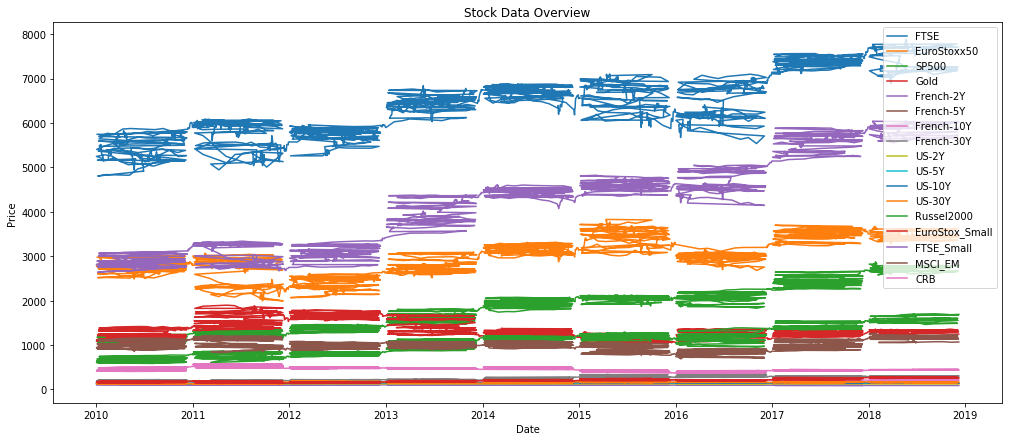

In [10]:
# Taking a quick look at our data
plt.figure(figsize=(17,7))
plt.plot(stock_prices)
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Stock Data Overview')
plt.legend(stock_prices.columns)
plt.show()

## HCAA Portfolio Build

The HCAA portfolio in this example will be built utilizing the HierarchicalClusteringAssetAllocation() class provided through MlFinLab. In order to implement this portfolio optimization, we will run the allocate method with three parameters:
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)
3. allocation_metric (the type of solution/algorithm to use to calculate the weights)

The MlFinLab library also supports many more customizable parameters which can be used as well. Users can also specify:
1. The metric used for calculating weight allocations
2. A covariance matrix and expected asset returns instead of historical prices
3. The type of linkage algorithm being used
4. The optimal number of clusters for hierarchical clustering
5. The confidence level for calculating expected shortfall and conditional drawdown at risk
6. The method to use for calculation of expected returns

For simplicity we will only be constructing the HCAA portfolio with the three required parameters, utilizing the Minimum Variance portfolio solution for calculating weight allocations. Keep in mind that the default linkage algorithm is set as the Ward Linkage algorithm.

If you would like to learn more about this implementation and how you can utilize these additional parameters, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__. 

In [19]:
# building our HCAA portfolio
hcaa = HierarchicalClusteringAssetAllocation()
hcaa.allocate(asset_names=stock_prices.columns,
              asset_prices=stock_prices,
              allocation_metric='equal_weighting')
hcaa.weights

,Gold,CRB,SP500,Russel2000,FTSE,EuroStoxx50,EuroStox_Small,FTSE_Small,MSCI_EM,US-2Y,US-30Y,US-5Y,US-10Y,French-10Y,French-30Y,French-2Y,French-5Y
0,0.021999,0.011912,0.080403,0.125,0.113293,0.011707,0.10453,0.02047,0.233675,0.012477,0.003181,0.000667,0.044597,0.015624,0.055057,0.020408,0.125


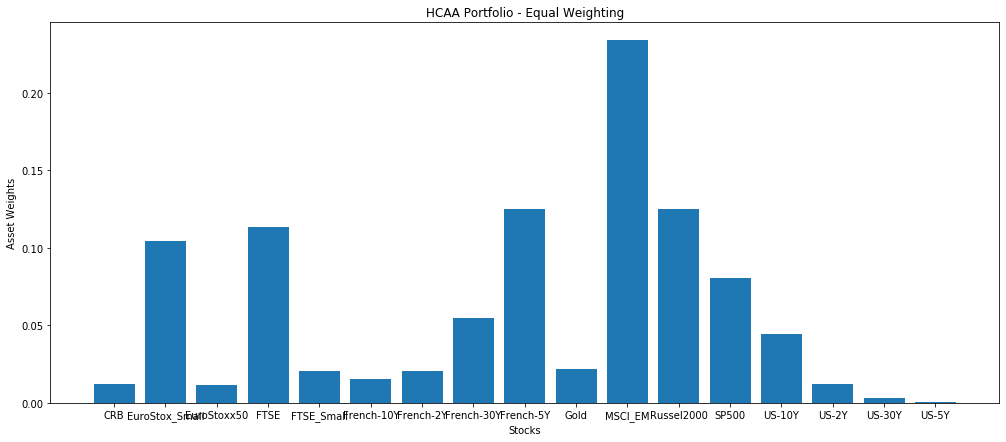

In [23]:
# plotting our HCAA portfolio
hcaa_weights = hcaa.weights[sorted(hcaa.weights)]
hcaa_weights = hcaa_weights.values.tolist()
hcaa_weights = [item for sublist in hcaa_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, hcaa_weights)
plt.xticks(y_pos, sorted(hcaa.weights))
plt.xlabel('Stocks')
plt.ylabel('Asset Weights')
plt.title('HCAA Portfolio - Equal Weighting')
plt.show()

## HRP Portfolio Build
The HRP portfolio in this example will be built through the HierarchicalRiskParty() class provided through MlFinLab. Slightly different from the HCAA implementation, the HRP portfolio build will utilize the following two parameters:
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)

Similarly to the HCAA implementation, users also have acces to a great degree of customizability when working with the HRP implementation. Specificaly, MlFinLab allows users to specify:
1. Whether to shrink the covariance or not
2. How to resample the prices if needed
3. The type of linkage algorithm being used for clustering

Users are also given the option to provide a matrix of asset returns, a covariance matrix of asset returns, and a distance matrix instead of the raw historical prices if they like. For simplicity, we will only be working with the two necessary parameters, the asset names and the asset prices.

If you would like to learn more about the HRP implementation, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_risk_parity.html)__.

In [14]:
# building our HRP portfolio
hrp = HierarchicalRiskParity()
hrp.allocate(asset_names=stock_prices.columns,
             asset_prices=stock_prices)
hrp.weights

,US-2Y,US-30Y,US-5Y,US-10Y,French-2Y,French-5Y,French-10Y,French-30Y,Gold,CRB,SP500,Russel2000,MSCI_EM,FTSE_Small,FTSE,EuroStoxx50,EuroStox_Small
0,0.509853,0.001454,0.016473,0.0042,0.405164,0.041865,0.007973,0.001561,0.00104,0.006736,0.000732,0.000406,0.000495,0.001334,0.000431,0.000122,0.00016


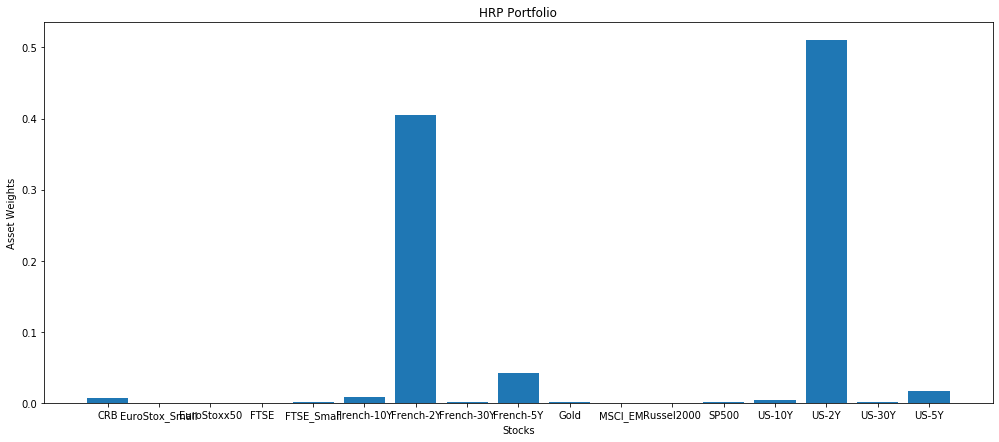

In [24]:
# plotting our HRP portfolio
hrp_weights = hrp.weights[sorted(hrp.weights)]
hrp_weights = hrp_weights.values.tolist()
hrp_weights = [item for sublist in hrp_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, hrp_weights)
plt.xticks(y_pos, sorted(hrp.weights))
plt.xlabel('Stocks')
plt.ylabel('Asset Weights')
plt.title('HRP Portfolio')
plt.show()

We can also take advantage of the plot_clusters method to visualize the portfolio clusters through a dendrogram. We can see how the similar assets in this example are being clustered together at early stages of our tree.

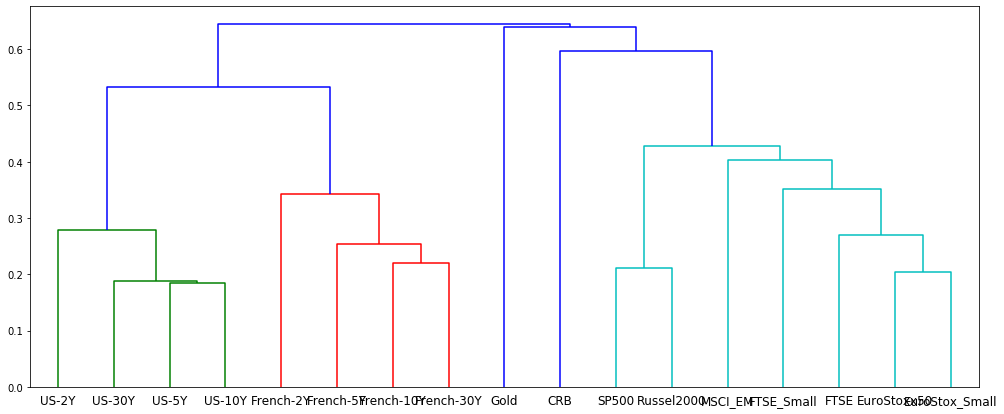

In [38]:
# plotting dendrogram of HRP portfolio
plt.figure(figsize=(17,7))
hrp.plot_clusters(stock_prices.columns)
plt.show()

## Comparison of Algorithms
- The HRP algorithm uses a Single Linkage algorithm and grows the tree to the maximum depth. This method may not identify the optimal number of clusters and can sometimes lead to sub-optimal results. In contrast, the HCAA algorithm first calculates the optimal number of clusters and then cuts the tree to the required height and clusters.
- The two algorithms also differ when performing the Top-Down recursive bisection to each tree. The HRP algorithm breaks the tree down the middle based on the number of assets while the HCAA algorithms divides the tree based on the fundamental structure of the dendrogram produced.

From here, we can understand the fundamental differences as to how the algorithms work. We can also plot the results of both algorithms to see how these different processes result in different asset allocations for each portfolio.

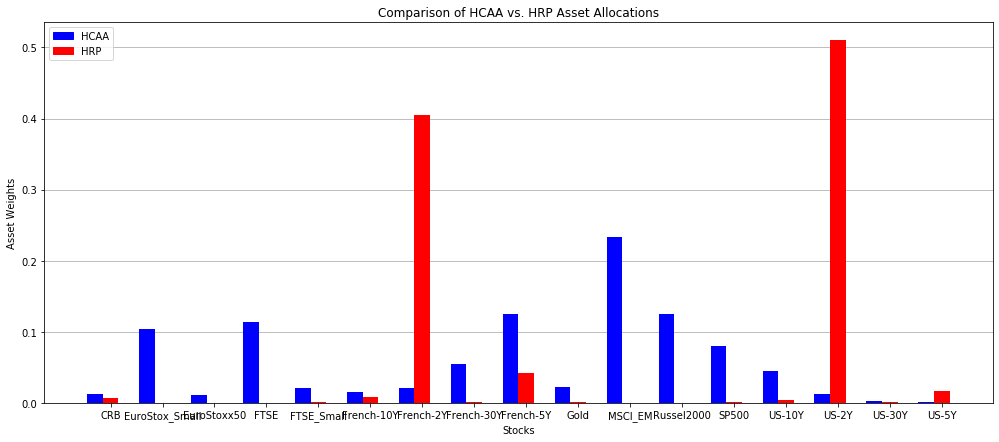

In [30]:
# plotting our comparison graph
x = np.arange(len(hcaa_weights))
bar_width = 0.3

plt.figure(figsize=(17,7))
plt.bar(x, hcaa_weights, color='blue', width=bar_width, zorder=2)
plt.bar(x + bar_width, hrp_weights, color='red', width=bar_width, zorder=2)

plt.xticks(x + bar_width, sorted(hcaa.weights))
plt.title('Comparison of HCAA vs. HRP Asset Allocations')
plt.xlabel('Stocks')
plt.ylabel('Asset Weights')

blue_patch = mpatches.Patch(color='blue', label='HCAA')
red_patch = mpatches.Patch(color='red', label='HRP')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

plt.grid(axis='y')

plt.show()

Through this comparison graph, we can see how the separate algorithms provide different asset allocations for their respective portfolios. If you would like to learn more about each algorithm please refer to the sources section at the bottom of this notebook.

## Conclusion

Throughout this notebook, users were taken through how they can implement the Hierarchical Clustering Asset Allocation and Hierarchical Risk Parity algorithms through the MlFinLab library. Users were also given insight as to the different factors which separate the algorithms from one another. By visualizing the different portfolios produced by each algorithm, users can see the affects of each algorithm and their respective properties.

## Sources
Official MlFinLab Documentation:
- __[Hierarchical Clustering Asset Allocation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__
- __[Hierarchical Risk Parity](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_risk_parity.html)__

Algorithms:
- __[Hierarchical Risk Parity - Hudson & Thames](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__
- __[Hierarchical Equal Risk Contribution - Thomas Raffinot](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3237540)__
- __[Hierarchical Clustering Based Asset Allocation - Thomas Raffinot](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2840729)__